# Imports

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import sys
import copy
import pickle
from sklearn.metrics import normalized_mutual_info_score
from scipy.sparse.csgraph import connected_components


sys.path.append('/home/nico/VSCodeRepos/SigMA/')
from SigMA.SigMA import SigMA
from miscellaneous.error_sampler import ErrorSampler
from velocity_testing.velocity_test import VelocityTester
from NoiseRemoval.RemoveNoiseTransformed import remove_noise_simple
from generate_data import DataGenerator

# Plotting Function

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#plt_colors = [
#    '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3',
#    '#FF6692', '#B6E880', '#FF97FF', '#FECB52', '#B82E2E', '#316395'
#]

def plot_3D_data(data, xyz_titles=['X', 'Y', 'Z'], ax_range=[-40, 40], labels=None, true_labels=None):
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{"type": "scatter3d"}]],
        column_widths=[1],
        subplot_titles=[
            '3D', 
        ],
    )

    # if true labels is not none, get rid of cluster -1
    if true_labels is not None:
        data = data.loc[true_labels != -1]
        # true_labels = true_labels[true_labels != -1]
        labels = labels[true_labels != -1]
    print(np.unique(labels, return_counts=True))

    # --------------- 3D scatter plot -------------------
    if labels is None:
        trace_3d = go.Scatter3d(
            x=data.loc[:, xyz_titles[0]], y=data.loc[:, xyz_titles[1]], z=data.loc[:, xyz_titles[2]],
            mode='markers',
            marker=dict(size=5, color='red'),
            hoverinfo='none',
            showlegend=False,
        )
        fig.add_trace(trace_3d, row=1, col=1)
    else:
        for l_i in np.unique(labels):
            if l_i != -1:
                trace_3d = go.Scatter3d(
                    x=data.loc[labels==l_i, xyz_titles[0]], y=data.loc[labels==l_i, xyz_titles[1]], z=data.loc[labels==l_i, xyz_titles[2]],
                    mode='markers',
                    marker=dict(size=5),
                    hoverinfo='none',
                    showlegend=True,
                    name=f'Cluster {l_i}'
                )
                fig.add_trace(trace_3d, row=1, col=1)
    
    # 3d position
    plt_kwargs = dict(showbackground=False, showline=False, zeroline=True, zerolinecolor='grey', zerolinewidth=2, 
                      showgrid=True, showticklabels=True, color='black',
                      linecolor='black', linewidth=1,  gridcolor='rgba(100,100,100,0.5)')

    xaxis=dict(**plt_kwargs, title=xyz_titles[0], range=ax_range)
    yaxis=dict(**plt_kwargs, title=xyz_titles[1], range=ax_range)
    zaxis=dict(**plt_kwargs, title=xyz_titles[2], range=ax_range)

    # Finalize layout
    fig.update_layout(
        title="",
        #width=800,
        #height=800,
        showlegend=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        legend= dict(itemsizing='constant', font_color='black'),
        # 3D plot
        scene=dict(
            xaxis=dict(xaxis),
            yaxis=dict(yaxis),
            zaxis=dict(zaxis)
        )
    )
    fig.write_html(f"/home/nico/Desktop/evaluation_data/simulated_cluster_{'sigma' if true_labels is not None else 'true'}.html")

# Test Cases & Summary

In [4]:
# contains true split
test_case_1 = [
    {
        'clusters': [0, 1],
        'mu_position': [
            [-500, -500, 20],
            [-490, -490, 35]
        ],
        'mu_std': [
            np.array([3, 5, 2]),
            np.array([4, 8, 2])
        ]
    }
]

# contains true split
test_case_2 = [
    {
        'clusters': [0, 2],
        'mu_position': [
            [20, 40, 150],
            [20, 40, 150]
        ],
        'mu_std': [
            np.array([7, 3, 4]),
            np.array([6, 5, 5])
        ]
    }
]

# contains true split
test_case_3 = [
    {
        'clusters': [0, 3],
        'mu_position': [
            [-20, 40, 160],
            [-20, 40, 140]
        ],
        'mu_std': [
            np.array([5, 7, 3]),
            np.array([4, 5, 3])
        ]
    }
]

# contains true split
test_case_4 = [
    {
        'clusters': [0, 4],
        'mu_position': [
            [-20, 300, 160],
            [-20, 300, 150]
        ],
        'mu_std': [
            np.array([4, 3, 4]),
            np.array([6, 5, 4])
        ]
    }
]

# contains true split
test_case_5 = [
    {
        'clusters': [0, 5],
        'mu_position': [
            [-20, 300, 170],
            [-20, 300, 160]
        ],
        'mu_std': [
            np.array([4, 3, 4]),
            np.array([6, 5, 4])
        ]
    }
]

# contains a few noise splits
test_case_6 = [
    {
        'clusters': [1, 2],
        'mu_position': [
            [-30, -150, 180],
            [-30, -150, 160]
        ],
        'mu_std': [
            np.array([4, 2, 4]),
            np.array([6, 6, 4])
        ]
    }
]

# contains a true split
test_case_7 = [
    {
        'clusters': [1, 3],
        'mu_position': [
            [-30, 150, 180],
            [-30, 150, 160]
        ],
        'mu_std': [
            np.array([5, 7, 7]),
            np.array([4, 4, 7])
        ]
    }
]

# contains a true split
test_case_8 = [
    {
        'clusters': [1, 4],
        'mu_position': [
            [200, -150, 0],
            [200, -170, 0]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([7, 7, 7])
        ]
    }
]

# contains a true split
test_case_9 = [
    {
        'clusters': [1, 5],
        'mu_position': [
            [100, 200, -150],
            [100, 200, -150]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([7, 7, 7])
        ]
    }
]

# contains a true split
test_case_10 = [
    {
        'clusters': [2, 3],
        'mu_position': [
            [-100, 200, -150],
            [-100, 200, -150]
        ],
        'mu_std': [
            np.array([4, 4, 3]),
            np.array([7, 5, 7])
        ]
    }
]

# contains a true split and 2 noise splits
test_case_11 = [
    {
        'clusters': [2, 4],
        'mu_position': [
            [-100, 300, -150],
            [-100, 300, -150]
        ],
        'mu_std': [
            np.array([7, 7, 7]),
            np.array([7, 7, 7])
        ]
    }
]

# contains 5 noise spilts
test_case_12 = [
    {
        'clusters': [2, 5],
        'mu_position': [
            [-100, 400, -150],
            [-100, 400, -150]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([3, 3, 3])
        ]
    }
]

# contains a few noise splits
test_case_13 = [
    {
        'clusters': [3, 4],
        'mu_position': [
            [270, 200, 300],
            [270, 200, 300]
        ],
        'mu_std': [
            np.array([4, 3, 7]),
            np.array([4, 5, 5])
        ]
    }
]

# contains a few noise splits
test_case_14 = [
    {
        'clusters': [3, 5],
        'mu_position': [
            [260, -100, 200],
            [260, -100, 200]
        ],
        'mu_std': [
            np.array([4, 3, 7]),
            np.array([4, 5, 6])
        ]
    }
]

# can contain a wrong split
test_case_15 = [
    {
        'clusters': [0, 0],
        'mu_position': [
            [260, -90, 200],
            [260, -115, 200]
        ],
        'mu_std': [
            np.array([4, 3, 7]),
            np.array([4, 5, 6])
        ]
    }
]

# can contain a wrong split
test_case_16 = [
    {
        'clusters': [1, 1],
        'mu_position': [
            [120, 20, 200],
            [120, -10, 200]
        ],
        'mu_std': [
            np.array([5, 7, 7]),
            np.array([4, 7, 7])
        ]   
    }
]

# can contain a wrong split
test_case_17 = [
    {
        'clusters': [2, 2],
        'mu_position': [
            [400, 400, 400],
            [360, 400, 400]
        ],
        'mu_std': [
            np.array([7, 7, 4]),
            np.array([7, 7, 4])
        ]   
    }
]

# can contain a wrong split
test_case_18 = [
    {
        'clusters': [3, 3],
        'mu_position': [
            [400, 250, 400],
            [400, 265, 400]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([3, 3, 3])
        ]   
    }
]

# can contain a wrong split
test_case_19 = [
    {
        'clusters': [4, 4],
        'mu_position': [
            [-100, 250, 400],
            [-127, 250, 400]
        ],
        'mu_std': [
            np.array([4, 6, 7]),
            np.array([4, 2, 5])
        ]   
    }
]

# can contain a wrong split
test_case_20 = [
    {
        'clusters': [5, 5],
        'mu_position': [
            [200, -350, 150],
            [230, -350, 150]
        ],
        'mu_std': [
            np.array([7, 5, 4]),
            np.array([3, 3, 5])
        ]   
    }
]

# total about:
# - 10 true splits
# - 10 noise splits
# - 5 wrong splits

# combine the test cases
test_cases = test_case_1 + test_case_2 + test_case_3 + test_case_4 + test_case_5 + test_case_6 + test_case_7 + test_case_8 + test_case_9 + test_case_10 + test_case_11 + test_case_12 + test_case_13 + test_case_14 + test_case_15 + test_case_16 + test_case_17 + test_case_18 + test_case_19 + test_case_20

In [5]:
# create an overview over all test cases using a dataframe
# we need the cluster ids, the mean positions and stds of each cluster in the test
# also the number of samples in each cluster and the mean velocities and stds

# create a dataframe for the test cases
data_generator = DataGenerator()
df_test_cases = pd.DataFrame()
for i, test_case in enumerate(test_cases):
    for labels, mu_position, mu_std in zip(test_case['clusters'], test_case['mu_position'], test_case['mu_std']):
        mu_velocity = data_generator.df_infos[['U', 'V', 'W']].iloc[labels].values
        std = np.concatenate((mu_std, data_generator.df_infos[['U_std', 'V_std', 'W_std']].iloc[labels].values))
        N = max(int(data_generator.df_infos[['n_cluster']].iloc[labels].values), 200)
        df_test_cases = pd.concat([df_test_cases, pd.DataFrame({
            'test_case': i,
            'cluster': labels,
            'mu_position': [mu_position],
            'mu_std': [mu_std],
            'N': [N],
            'mu_velocity': [mu_velocity],
            'std': [std]
        })])

In [6]:
# calculate difference between the positions, velocities and stds
for i in df_test_cases['test_case'].unique():
    for col in ['mu_position', 'mu_velocity', 'std']:
        positions = df_test_cases.loc[df_test_cases['test_case'] == i, col].apply(np.array)
        diff = np.diff(positions.values, axis=0)
        df_test_cases.loc[df_test_cases['test_case'] == i, f'diff_{col}'] = np.linalg.norm(diff[0])

# Data Creation

In [5]:
data_generator = DataGenerator()
data_generator.generate_data(test_case_4)
data, labels_true, err_sampler = data_generator.add_noise(n_samples=50000)

In [6]:
cols = ['X', 'Y', 'Z']
# cols = ['ra', 'dec', 'parallax']
# cols = ['U', 'V', 'W']
# cols = ['pmra', 'pmdec', 'radial_velocity']
plot_3D_data(data, xyz_titles=cols, ax_range=[-1000, 1000], labels=labels_true, true_labels=None)

(array([-1,  0,  1]), array([50000,   305,   274]))


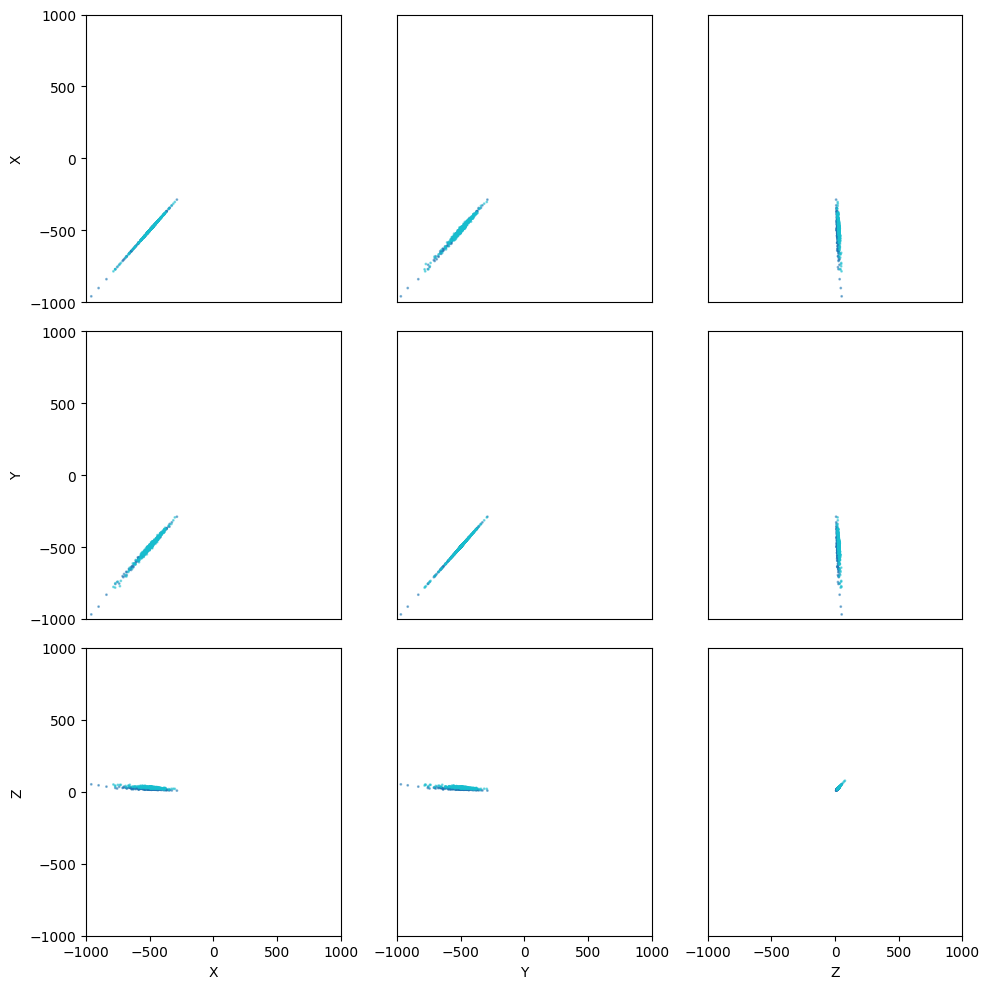

In [37]:
import matplotlib.pyplot as plt

data_no_noise = copy.deepcopy(data)
data_no_noise = data_no_noise[labels_true != -1]
labels_true_no_noise = copy.deepcopy(labels_true)
labels_true_no_noise = labels_true_no_noise[labels_true != -1]

# create a scatterplot matrix in matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        axes[i, j].scatter(data_no_noise[cols[j]], data_no_noise[cols[i]], s=1, c=labels_true_no_noise, cmap='tab10', alpha=0.5)

        axes[i, j].set_xlim(-1000, 1000)
        axes[i, j].set_ylim(-1000, 1000)
        # get rid of right and top spines
        # only show ticks on the most left and bottom axes
        if i == 2:
            axes[i, j].set_xlabel(cols[j])
            axes[i, j].set_xticks([-1000, -500, 0, 500, 1000])
        else:
            axes[i, j].set_xticks([])
        if j == 0:
            axes[i, j].set_ylabel(cols[i])
            axes[i, j].set_yticks([-1000, -500, 0, 500, 1000])
        else:
            axes[i, j].set_yticks([])
# fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.show()

# Plotting SigMA

In [176]:
def extract_cluster_single(label_bool_arr, clusterer):
    cluster_bool_array = remove_noise_simple(label_bool_arr, te_obj=clusterer)
    if cluster_bool_array is not None:
        return cluster_bool_array
    else:
        data_idx = np.arange(clusterer.X.shape[0])
        rho = clusterer.weights_[label_bool_arr]
        mad = np.median(np.abs(rho - np.median(rho)))
        threshold = np.median(rho)*0.995 + 3 * mad * 1.05
        # Statistisch fundierterer cut
        # threshold = np.median(rho) + 3 * mad
        idx_cluster = data_idx[label_bool_arr][rho > threshold]
        if len(idx_cluster) > 20:
            # labels_with_noise[idx_cluster] = i
            # Only graph connected points allowed
            _, cc_idx = connected_components(clusterer.A[idx_cluster, :][:, idx_cluster])
            # Combine CCs data points with originally defined dense core (to not miss out on potentially dropped points)
            idx_cluster = data_idx[idx_cluster][cc_idx == np.argmax(np.bincount(cc_idx))]
        
        cluster_bool_array = np.isin(data_idx, idx_cluster)
        return cluster_bool_array

In [177]:
def extract_signal(clusterer, labels):
    labels_with_noise = -np.ones(clusterer.X.shape[0], dtype=int)
    for i, u_cl in enumerate(np.unique(labels[labels>-1])):
        cluster_bool_array = extract_cluster_single(labels==u_cl, clusterer)
        labels_with_noise[cluster_bool_array] = i
        
    return labels_with_noise

In [182]:
cols2fit = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
df_fit = copy.deepcopy(data[cols2fit])
# Scale features
sf = {
    'ra': 1/0.64,
    'dec': 1/0.65,
    'parallax': 1/0.15,
    'pmra': 1/0.49,
    'pmdec': 1/0.57
}
for col in cols2fit:
    df_fit[col] *= sf[col]

sigma_kwargs = dict(
    cluster_features=cols2fit,
    scale_factors=None,
    # These are the default values and should be kept for now
    nb_resampling=0, max_knn_density=101,
    beta=0.99, knn_initcluster_graph=40,
    transform_function=None
)
clusterer = SigMA(data=df_fit, **sigma_kwargs).fit(alpha=0.01, knn=15, bh_correction=True)

Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 3.46e-05


In [185]:
nmi_data = {}
labels_pred = extract_signal(clusterer, clusterer.labels_)
nmi_data['sigma'] = normalized_mutual_info_score(labels_true, labels_pred)
nmi_data

{'sigma': 0.00949519460115467}

In [186]:
np.unique(clusterer.labels_, return_counts=True)

(array([   66,   447,  6272, 11299, 37278, 43180]),
 array([  316,   292, 29992, 10884,  7169,  1926]))

In [180]:
np.unique(labels_pred, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([49676,     4,     2,    45,    78,    26,   748]))

In [184]:
cols = ['X', 'Y', 'Z']
plot_3D_data(data, xyz_titles=cols, ax_range=[-1000, 1000], labels=clusterer.labels_, true_labels=labels_true)
# plot_3D_data(data, xyz_titles=cols, ax_range=[-1000, 1000], labels=clusterer.labels_, true_labels=None)

(array([ 66, 447]), array([306, 273]))


# Run Test

In [187]:
def produce_baseline(clusterer):
    _, p_values = clusterer.run_sigma(
        alpha=-np.inf, knn=15, return_pvalues=True
    )
    p_values = np.array(p_values)
    pv_sorted = np.sort(p_values[p_values < 0.05])
    # compute mid point between consecutive p-values
    mid_points = (pv_sorted[1:] + pv_sorted[:-1]) / 2
    return mid_points, clusterer.labels_

mid_points, l0 = produce_baseline(clusterer)

In [188]:
np.unique(labels_true, return_counts=True)

(array([-1,  0,  1]), array([50000,   305,   274]))

In [189]:
# check whether the needed split happens
for alpha_i in mid_points:
    clusterer = clusterer.fit(alpha=alpha_i, knn=15, bh_correction=False)
    l_i = clusterer.labels_
    new_cluster_id = list(set(l_i) - set(l0))
    if len(new_cluster_id) == 1:
        nc_id = new_cluster_id[0]
        part_of_old_cluster = mode(l0[l_i==nc_id], keepdims=False).mode
        print(f'New cluster {nc_id} from old cluster {part_of_old_cluster}')

    
        # check the true labels of the two clusters
        labels_new, count_new = np.unique(labels_true[l_i==nc_id], return_counts=True)
        labels_old, count_old = np.unique(labels_true[l_i==part_of_old_cluster], return_counts=True)

        print(f'New cluster labels: {labels_new}, counts: {count_new}')
        print(f'Old cluster labels: {labels_old}, counts: {count_old}')

    elif len(new_cluster_id) > 1:
        print('More than one new cluster id')
    else:
        print('No new cluster id')

    l0 = np.copy(l_i)

No new cluster id
New cluster 447 from old cluster 66
New cluster labels: [-1  0  1], counts: [ 19   6 267]
Old cluster labels: [-1  0  1], counts: [37171   299     7]
New cluster 6272 from old cluster 66
New cluster labels: [-1], counts: [37161]
Old cluster labels: [-1  0  1], counts: [ 10 299   7]
New cluster 37278 from old cluster 6272
New cluster labels: [-1], counts: [7169]
Old cluster labels: [-1], counts: [29992]
New cluster 43180 from old cluster 11299
New cluster labels: [-1], counts: [1926]
Old cluster labels: [-1], counts: [10884]
New cluster 41191 from old cluster 11299
New cluster labels: [-1], counts: [158]
Old cluster labels: [-1], counts: [10726]
New cluster 17663 from old cluster 6272
New cluster labels: [-1], counts: [855]
Old cluster labels: [-1], counts: [29137]
New cluster 31926 from old cluster 6272
New cluster labels: [-1], counts: [67]
Old cluster labels: [-1], counts: [29070]
New cluster 18717 from old cluster 6272
New cluster labels: [-1], counts: [474]
Old cl

KeyboardInterrupt: 

In [190]:
def update_labels(labels, label_old, label_new):
    updated_labels = copy.deepcopy(labels)
    updated_labels[labels == label_new] = label_old
    return updated_labels

In [191]:
# save the cluster labels to a csv file
data.to_csv('/home/nico/Desktop/test_case/data.csv', index=False)
np.save('/home/nico/Desktop/test_case/labels_true.npy', labels_true)

cluster_labels = pd.DataFrame({'sigma': l0})

In [192]:
nmi_data

{'sigma': 0.00949519460115467}

In [196]:
%reload_ext autoreload
%autoreload 2

test_strategies = [
    #'ttest', 
    #'bootstrap_range_test',
    #'bootstrap_difference_test',
    'xd_mean_distance', 
    #'error_sample_ttest', 
    #'xd_mean_distance_sample_distance', 
    #'error_sample_bootstrap_range_test'
]

for test_strat in test_strategies:
    print(f'Running test strategy {test_strat}')
    split_info = []
    velocity_tester = VelocityTester(data, clusterer.weights_, test_strat, clusterer, err_sampler)
    iteration = 1
    last_alpha = None
    l0 = cluster_labels['sigma'].values

    # produce the splits for each alpha
    for alpha_i in mid_points:
        # fit clusterer to new alpha
        clusterer = clusterer.fit(alpha=alpha_i, knn=15, bh_correction=False)
        l_i = clusterer.labels_
        new_clusters_id = list(set(l_i) - set(l0))

        alpha_difference = alpha_i - last_alpha if last_alpha is not None else None
        while len(new_clusters_id) > 1:
            # update alpha to the mean of the mid points
            new_alpha = last_alpha + alpha_difference

            # fit clusterer to new alpha
            clusterer = clusterer.fit(alpha=new_alpha, knn=15, bh_correction=False)
            l_i = clusterer.labels_
            new_clusters_id = list(set(l_i) - set(l0))

            # update alpha difference
            alpha_difference = alpha_difference / 2

            print(f'New alpha: {new_alpha} Last alpha: {last_alpha}, new clusters: {len(new_clusters_id)}')

        if len(new_clusters_id) == 1: 
            # one new cluster was generated
            nc_id = new_clusters_id[0]
            part_of_old_cluster = mode(l0[l_i==nc_id], keepdims=False).mode
            print(f'New cluster {nc_id} from old cluster {part_of_old_cluster}')

            # iterate splits
            l_updated = np.copy(l_i)
            for split in reversed(split_info):
                if split['same_velocity'] == True:
                    l_updated = update_labels(l_updated, split['old_cluster'], split['new_cluster'])
                    if part_of_old_cluster == split['new_cluster']:
                        part_of_old_cluster = split['old_cluster']
                    # print(f'New cluster {splits[split]["new_cluster"]} was updated to old cluster {splits[split]["old_cluster"]}')
                        
            # get some information for the report
            labels_nc_id, count_nc_id = np.unique(labels_true[l_updated==nc_id], return_counts=True)
            # print(f'New cluster {nc_id} has the following true labels: {labels_nc_id} with counts {count_nc_id}')
            labels_part_of_old_cluster, count_part_of_old_cluster = np.unique(labels_true[l_updated==part_of_old_cluster], return_counts=True)
            # print(f'Old cluster {part_of_old_cluster} has the following true labels: {labels_part_of_old_cluster} with counts {count_part_of_old_cluster}')
            
            # if both clusters only have labels -1, skip the velocity test as otherwise testing would take too long
            same_velocity = False
            test_output = 'none'
            if len(labels_nc_id) == 1 and labels_nc_id[0] == -1 and len(labels_part_of_old_cluster) == 1 and labels_part_of_old_cluster[0] == -1:
                print('Skipping velocity test')
                same_velocity = True
                test_output = 'skipped'
                mean_deviation = 0
                stats = None
            else:
                test_output, mean_deviation, stats = velocity_tester.run_test(l_updated, part_of_old_cluster, nc_id, clusterer, return_stats=True)
                same_velocity = test_output
                test_output = 'same velocity' if test_output else 'different velocity'

            # check if the mean_deviation is larger than 10
            if max(mean_deviation) > 10:
                same_velocity = True
                test_output += ' deviation overwrite'



            split_info.append({
                'new_cluster': nc_id,
                'old_cluster': part_of_old_cluster,
                'alpha': alpha_i,
                'same_velocity': same_velocity,
                'test_output': test_output,
                'mean_deviation': mean_deviation,
                'stats': stats,
                'labels_nc_id': labels_nc_id,
                'count_nc_id': count_nc_id,
                'labels_part_of_old_cluster': labels_part_of_old_cluster,
                'count_part_of_old_cluster': count_part_of_old_cluster
            })

            print(f'Test output: {test_output}, same velocity: {same_velocity}, mean deviation: {mean_deviation}')


        else:
            print('No new cluster')
        # print(f'Finished iteration {iteration}')
        iteration += 1
        l0 = np.copy(l_i)
        last_alpha = alpha_i
    print('-------------------\n')


    # quicksave the labels to a csv file
    cluster_labels.to_csv('/home/nico/Desktop/test_case/cluster_labels.csv', index=False)
    # save the split info with pickle
    with open(f'/home/nico/Desktop/test_case/split_info_{test_strat}.pkl', 'wb') as f:
        pickle.dump(split_info, f)

    # compute nmi
    clusterer = clusterer.fit(alpha=mid_points[-1], knn=15, bh_correction=False)  
    labels = clusterer.labels_
    l_updated = np.copy(labels)
    for split in reversed(split_info):
        if split_info[split]['same_velocity'] == True:
            l_updated = update_labels(l_updated, split_info[split]['old_cluster'], split_info[split]['new_cluster'])
    cluster_labels[test_strat] = l_updated

    labels_pred = extract_signal(clusterer, l_updated)
    nmi_data[test_strat] = normalized_mutual_info_score(labels_true, labels_pred)

    # save the nmi data to a csv file
    nmi_df = pd.DataFrame(nmi_data.items(), columns=['strategy', 'nmi'])
    nmi_df.to_csv('/home/nico/Desktop/test_case/nmi.csv', index=False)

Running test strategy xd_mean_distance
No new cluster
New cluster 447 from old cluster 66
Test output: different velocitydeviation overwrite, same velocity: True, mean deviation: 201.3769102096447
New cluster 6272 from old cluster 66
Test output: different velocitydeviation overwrite, same velocity: True, mean deviation: 1864.044748772043
New cluster 37278 from old cluster 6272
Test output: different velocitydeviation overwrite, same velocity: True, mean deviation: 595.0862357038504
New cluster 43180 from old cluster 11299
Skipping velocity test
Test output: skipped, same velocity: True, mean deviation: 0
New cluster 41191 from old cluster 11299
Skipping velocity test
Test output: skipped, same velocity: True, mean deviation: 0
New cluster 17663 from old cluster 6272
Test output: different velocitydeviation overwrite, same velocity: True, mean deviation: 1000
New cluster 31926 from old cluster 6272
Test output: different velocitydeviation overwrite, same velocity: True, mean deviation: